In [10]:
import os 
import random
import numpy as np
from PIL import Image

from datetime import datetime
import pickle
from tqdm import tqdm #loading bar  

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as ParentDataset

from torchvision import transforms
from torchvision.transforms import Compose

import sklearn.metrics

import segmentation_models_pytorch as smp #model we're using for now. 
import evaluateModel

In [11]:
#Errors associated to potantial randomness / non-deterministic behaviour is a VERY common issue in PT. 
#Look at the following github discussion for more information: 
#https://github.com/pytorch/pytorch/issues/7068
#      sbelharbi commented on Apr 19, 2019

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [12]:
#This is related to the init function of the worker(s) to be fed to the DataLoader
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [78]:
class TBI_dataset(ParentDataset): #Obtain the attributes of ParentDataset from torch.utils.data
#Finds Image and Label locations, creates random list of indicies for training / val / testing sets to be called
    def __init__(
        self,
        images_dir,
        labels_dir,
        train_size = 0.75, #fraction of total number of samples to be used in training set
        subset="train",
        transform = None, #base transformation is into Tensor. 
        random_sampling=True,
        seed=42, #We'll get the same thing everytime if we keep using the same seed. 
    ):
        #filter and sort the list
        self.ImageIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(images_dir)))) 
        self.LabelIds = sorted(list(filter(('.DS_Store').__ne__,os.listdir(labels_dir))))
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ImageIds] #full_paths to slices
        self.labels_fps = [os.path.join(labels_dir, image_id) for image_id in self.LabelIds] #full_paths to labels
        
        if random_sampling == True:
            samples = list(range(0,len(self.images_fps))) #create a list of numbers
            random.seed(seed) #set the seed
            
            #random sample train_size amount and then do a train/validation split 
            indicies = random.sample(samples,round(train_size*len(samples)))
            self.val_indicies = indicies[0:round(len(indicies)*0.15)]
            self.train_indicies = indicies[round(len(indicies)*0.15) : len(indicies)]
            
            test_indicies = samples
            for j in sorted(indicies, reverse = True): #remove the train/val indicies from test set
                del test_indicies[j]
            
            #suffles without replacement. 
            self.test_indicies = random.sample(test_indicies, len(test_indicies)) 

        #We define a mapping to use when calling the Dataset loader based on the parameter "subset"
        if subset == "train":
            self.mapping = self.train_indicies
        elif subset == "val":
            self.mapping = self.val_indicies
        elif subset == "test":
            self.mapping = self.test_indicies
        else:
            print("subset parameter requires train, val, or test exactly.")
            
        self.transform = transform #trasform given by transform_function
            
    def __getitem__(self, ii): #ii is the index
        
        #Current implementations of transforms only use PIL images.
        #Apparently we can use np.array(Image.open(...)) to remove the error that happens each epoch
        image = Image.open(self.images_fps[self.mapping[ii]]) #open as PIL image. 
        label = Image.open(self.labels_fps[self.mapping[ii]])
         
        image = self.transform(image)
        label = self.transform(label)
             
        return image, label #, self.images_fps[self.mapping[ii]],self.labels_fps[self.mapping[ii]]
    
    def __len__(self):
        return len(self.mapping)
    
    
def datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob):
    train = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "train",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    valid = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset = "val",
        transform = transform_function(degrees=aug_angle, scale=aug_scale, flip_prob=flip_prob),
    )
    
    test = TBI_dataset(
        images_dir = images_dir,
        labels_dir = labels_dir,
        train_size = 0.75,
        subset="test",
        transform = transform_function(degrees=0, scale = [1,1], flip_prob = 0), #make sure nothing changes. 
    )
    
    return train, valid, test

def transform_function(degrees,scale,flip_prob):
    transform_list = []
    
    transform_list.append(transforms.RandomAffine(degrees, scale = scale))
    transform_list.append(transforms.RandomHorizontalFlip(p=flip_prob))
    transform_list.append(transforms.Pad(37)) #all images should be 182x182 before padding. 
    transform_list.append(transforms.ToTensor())
    
    return Compose(transform_list)

def Weights(labels):
    #expects an [batch_size,c,n,n] input 
    
    weights = []
    for batch_num in range(0,labels.shape[0]):
        num_ones = torch.sum(labels[batch_num,0,:,:]);
        resolution = labels.shape[2] * labels.shape[3]
        num_zeros = resolution - num_ones 
        weights.append(num_zeros / (num_ones + 1))
        
    #this keeps the clas imbalance in check
    return torch.Tensor(weights) #to ensure that we're getting a real number in the division  

In [79]:
train_size = 0.75
batch_size = 12
EPOCHS = 40
lr = 0.0001
aug_angle = 25
aug_scale = [1,1.5]
flip_prob = 0.5
num_workers = 1
images_dir = "/home/mccrinbc/Registered_Brains_FA/normalized_slices"
labels_dir = "/home/mccrinbc/Registered_Brains_FA/slice_labels"

#images_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_slices"
#labels_dir = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/test_labels"

#smp specific variables
ENCODER = 'resnet101'
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    #activation='softmax2d',    # activation function, default is None. This is the output activation. softmax2d specifies dim = 1 
    classes=1,                 # define number of output labels
)

#classes = 2 for the softmax transformation. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)

In [80]:
train_dataset, valid_dataset, test_dataset = datasets(images_dir, labels_dir, train_size, aug_angle, aug_scale, flip_prob)

In [81]:
test_dataset.transform

Compose(
    RandomAffine(degrees=(0, 0), scale=[1, 1])
    RandomHorizontalFlip(p=0)
    Pad(padding=37, fill=0, padding_mode=constant)
    ToTensor()
)

In [82]:
def train_validate(train_dataset, valid_dataset, lr):
    
    earlystop = False 
    
    if torch.cuda.is_available():
        dev ="cuda:2"
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    
    #this might break, remove worker_init_fn = _init_fn(num_workers)) if so
    train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True, num_workers = num_workers, worker_init_fn = _init_fn(num_workers))
    
    model.to(dev) #cast the model onto the device 
    optimizer = optim.Adam(model.parameters(), lr = lr) #learning rate should change 
    
    loss_function = torch.nn.BCELoss() #this takes in a weighted input and incorporates a sigmoid transformation
    #loss_function = smp.utils.losses.DiceLoss()
    #loss_function = DiceLoss()
    #metrics = [smp.utils.metrics.IoU(threshold=0.5)]
    
    loss_train = []
    loss_valid = []
    epochLoss_train = []
    epochLoss_valid = []
        
    for epoch in range(EPOCHS):
        image_count = 0
        for phase in ["train","val"]:
            
            #This determines which portions of the model will have gradients turned off or on. 
            if phase == "train":
                model.train() #put into training mode
                loader = train_loader
            else:
                model.eval() #evaluation mode.
                loader = valid_loader
                  
            for ii, data in enumerate(loader): 
                
                brains = data[0] #[batch_size,channels,height,width] 
                labels = data[1]
                
                image_count += len(brains)
                print(epoch, phase, ii, image_count)
                
                brains,labels = brains.to(dev), labels.to(dev) #put the data onto the device
                predictions, single_class = model(brains) #single class is not a useful output. 
                
                predictions = torch.sigmoid(predictions) #using this so that the output is bounded [0,1]
                single_class = torch.sigmoid(single_class)
                
                weights = Weights(labels) #generate the weights for each slice in the batch
                loss_function.pos_weight = weights                    
                
                loss = loss_function(predictions, labels) #loss changes here. 
                
                if phase == "train":
                    #employ this so we don't get multiples in the same list. 
                    if (loss_valid and ii == 0): #if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_valid.append(loss_valid[-1]) #append the last value in the 
                        
                    model.zero_grad() #recommended way to perform validation
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()
                    
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
               
                else:
                    if (loss_train and ii == 0):#if loss_valid is NOT empty AND it's the first time we see this
                        epochLoss_train.append(loss_train[-1]) #append the last value in the loss_train list.
                        
                    loss_valid.append(loss.item())
                    print(f"Phase: {phase}. Epoch: {epoch}. Loss: {loss.item()}") 
                    
                    #learning rate changes and early stopping
                    if epoch > 0:
                        if (epoch % 10) == 0: #if the epoch is divisable by 10
                            meanVal = np.mean(loss_valid[epoch - 10 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05: #if the %difference is small
                                for param_group in optimizer.param_groups:
                                    lr = lr * 0.1 #reduce the learning rate by a factor of 10. 
                                    param_group['lr'] = lr
                        
                        if (epoch % 50) == 0:
                            meanVal = np.mean(loss_valid[epoch - 50 : epoch])
                            if np.abs((meanVal - loss.item()) / meanVal) <= 0.05:
                                earlystop = True 
               
                #Implementation of early stopping
                if earlystop == True:
                    date = datetime.now()
                    torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) +"-EARLYSTOP.pt")) #save the model 
                    break
            else:
                continue
            break
        else:
            #save the model at the end of this epoch.
            #date = datetime.now()
            #torch.save(model.state_dict(), os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-epoch" + str(epoch) + '-' + str(date.date()) + '-' + str(date.hour) + '-' + str(date.minute) + ".pt"))
            continue
        break
    
    #Need to add the last element from loss_valid to epochLoss_valid to equal the number of epochs. 
    epochLoss_valid.append(loss_valid[-1])
    return brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model.state_dict()


In [83]:
def testModel(test_dataset, modelPath, threshold): #model = the model class = smp.UNet()

    total_images = 0
    CM_values = [0,0,0,0] #tp, fn, fp, tn
    model.load_state_dict(torch.load(modelPath))
    
    if torch.cuda.is_available():
        dev ="cuda:2"
        print("GPU is active")
    else:
        dev = "cpu"
        
    dev = torch.device(dev)
    model.to(dev) 
    model.eval() #evaluation mode to turn off the gradients / training. 
    
    loader = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = num_workers)
    for ii, data in tqdm(enumerate(loader)):
        
        brains = data[0]
        labels = data[1]
        
        #move the data to the GPU 
        brains = brains.to(dev)
        labels = labels.to(dev)
        
        total_images += brains.shape[0] #this would be the same if we used labels or predictions. 
        #print(total_images)
        
        predictions, _ = model(brains)
        predictions = torch.sigmoid(predictions) 
        
        predictions_numpy = predictions.cpu().detach().numpy()
        labels_numpy = labels.cpu().detach().numpy()
        for j in range(predictions.shape[0]):
            #labels = [False, True] are needed to make sure we don't have errors with the shape of CM
            CM = sklearn.metrics.confusion_matrix(labels_numpy[j,0,:,:].ravel(), predictions_numpy[j,0,:,:].ravel() > threshold, labels = [False,True])
            try: 
                CM_values[0] = CM_values[0] + CM[0][0]
                CM_values[1] = CM_values[1] + CM[0][1]
                CM_values[2] = CM_values[2] + CM[1][0]
                CM_values[3] = CM_values[3] + CM[1][1]
            except:
                print("Error in Appending")
                return CM, CM_values
            
    del loader #delete loader, might be wrong to do this
    return np.divide(CM_values , (total_images*(256*256)))


In [84]:
#Training Cell 

brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, model_state = train_validate(train_dataset, valid_dataset,lr)
    
date = datetime.now()
pkl_name = "results_TBI_model-End-" + str(date.date()) + '-' + str(date.hour) + '.pkl'

torch.save(model_state, os.path.join(os.getcwd(), "Registered_Brains_FA/models_saved", "TBI_model-End-" + str(date.date()) + '-' + str(date.hour) +".pt"))
    
# Saving the objects:
with open(pkl_name, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset], f)

0 train 0 12
Phase: train. Epoch: 0. Loss: 0.6250379085540771
0 train 1 24
Phase: train. Epoch: 0. Loss: 0.6110647916793823
0 train 2 36
Phase: train. Epoch: 0. Loss: 0.5951761603355408
0 train 3 48
Phase: train. Epoch: 0. Loss: 0.5900740027427673
0 train 4 60
Phase: train. Epoch: 0. Loss: 0.5789482593536377
0 train 5 72
Phase: train. Epoch: 0. Loss: 0.5733581781387329
0 train 6 84
Phase: train. Epoch: 0. Loss: 0.5606772899627686
0 train 7 96
Phase: train. Epoch: 0. Loss: 0.5485560894012451
0 train 8 108
Phase: train. Epoch: 0. Loss: 0.5412015318870544
0 train 9 120
Phase: train. Epoch: 0. Loss: 0.5280758738517761
0 train 10 132
Phase: train. Epoch: 0. Loss: 0.5128855109214783
0 train 11 144
Phase: train. Epoch: 0. Loss: 0.5076863765716553
0 train 12 156
Phase: train. Epoch: 0. Loss: 0.4938661456108093
0 train 13 168
Phase: train. Epoch: 0. Loss: 0.48401588201522827
0 train 14 180
Phase: train. Epoch: 0. Loss: 0.4794387221336365
0 train 15 192
Phase: train. Epoch: 0. Loss: 0.4621980190

Phase: train. Epoch: 1. Loss: 0.21892988681793213
1 train 55 672
Phase: train. Epoch: 1. Loss: 0.20699678361415863
1 train 56 684
Phase: train. Epoch: 1. Loss: 0.22551020979881287
1 train 57 696
Phase: train. Epoch: 1. Loss: 0.1998796910047531
1 train 58 708
Phase: train. Epoch: 1. Loss: 0.20827381312847137
1 train 59 720
Phase: train. Epoch: 1. Loss: 0.2165856808423996
1 train 60 732
Phase: train. Epoch: 1. Loss: 0.20399639010429382
1 train 61 744
Phase: train. Epoch: 1. Loss: 0.20331081748008728
1 train 62 751
Phase: train. Epoch: 1. Loss: 0.20443664491176605
1 val 0 763
Phase: val. Epoch: 1. Loss: 0.21381554007530212
1 val 1 775
Phase: val. Epoch: 1. Loss: 0.21084623038768768
1 val 2 787
Phase: val. Epoch: 1. Loss: 0.193674236536026
1 val 3 799
Phase: val. Epoch: 1. Loss: 0.20598113536834717
1 val 4 811
Phase: val. Epoch: 1. Loss: 0.2049371600151062
1 val 5 823
Phase: val. Epoch: 1. Loss: 0.22174833714962006
1 val 6 835
Phase: val. Epoch: 1. Loss: 0.21890076994895935
1 val 7 847
Pha

Phase: train. Epoch: 3. Loss: 0.15381458401679993
3 train 34 420
Phase: train. Epoch: 3. Loss: 0.16497547924518585
3 train 35 432
Phase: train. Epoch: 3. Loss: 0.20159554481506348
3 train 36 444
Phase: train. Epoch: 3. Loss: 0.15112578868865967
3 train 37 456
Phase: train. Epoch: 3. Loss: 0.16895195841789246
3 train 38 468
Phase: train. Epoch: 3. Loss: 0.16134345531463623
3 train 39 480
Phase: train. Epoch: 3. Loss: 0.18698863685131073
3 train 40 492
Phase: train. Epoch: 3. Loss: 0.1781396120786667
3 train 41 504
Phase: train. Epoch: 3. Loss: 0.17898428440093994
3 train 42 516
Phase: train. Epoch: 3. Loss: 0.16110122203826904
3 train 43 528
Phase: train. Epoch: 3. Loss: 0.1677739918231964
3 train 44 540
Phase: train. Epoch: 3. Loss: 0.1609068512916565
3 train 45 552
Phase: train. Epoch: 3. Loss: 0.16354387998580933
3 train 46 564
Phase: train. Epoch: 3. Loss: 0.15058687329292297
3 train 47 576
Phase: train. Epoch: 3. Loss: 0.15032994747161865
3 train 48 588
Phase: train. Epoch: 3. Loss

Phase: train. Epoch: 5. Loss: 0.18852321803569794
5 train 13 168
Phase: train. Epoch: 5. Loss: 0.14849211275577545
5 train 14 180
Phase: train. Epoch: 5. Loss: 0.1454683244228363
5 train 15 192
Phase: train. Epoch: 5. Loss: 0.12135422229766846
5 train 16 204
Phase: train. Epoch: 5. Loss: 0.1437118649482727
5 train 17 216
Phase: train. Epoch: 5. Loss: 0.13613013923168182
5 train 18 228
Phase: train. Epoch: 5. Loss: 0.16070708632469177
5 train 19 240
Phase: train. Epoch: 5. Loss: 0.13741159439086914
5 train 20 252
Phase: train. Epoch: 5. Loss: 0.1360650658607483
5 train 21 264
Phase: train. Epoch: 5. Loss: 0.12611286342144012
5 train 22 276
Phase: train. Epoch: 5. Loss: 0.1505991816520691
5 train 23 288
Phase: train. Epoch: 5. Loss: 0.16699472069740295
5 train 24 300
Phase: train. Epoch: 5. Loss: 0.1353302299976349
5 train 25 312
Phase: train. Epoch: 5. Loss: 0.13061532378196716
5 train 26 324
Phase: train. Epoch: 5. Loss: 0.11559176445007324
5 train 27 336
Phase: train. Epoch: 5. Loss: 

Phase: val. Epoch: 6. Loss: 0.10449719429016113
6 val 4 811
Phase: val. Epoch: 6. Loss: 0.10815578699111938
6 val 5 823
Phase: val. Epoch: 6. Loss: 0.10588155686855316
6 val 6 835
Phase: val. Epoch: 6. Loss: 0.1228455901145935
6 val 7 847
Phase: val. Epoch: 6. Loss: 0.12695449590682983
6 val 8 859
Phase: val. Epoch: 6. Loss: 0.15566658973693848
6 val 9 871
Phase: val. Epoch: 6. Loss: 0.14526045322418213
6 val 10 883
Phase: val. Epoch: 6. Loss: 0.1327233612537384
6 val 11 884
Phase: val. Epoch: 6. Loss: 0.05823555588722229
7 train 0 12
Phase: train. Epoch: 7. Loss: 0.11677964776754379
7 train 1 24
Phase: train. Epoch: 7. Loss: 0.1450834721326828
7 train 2 36
Phase: train. Epoch: 7. Loss: 0.13148805499076843
7 train 3 48
Phase: train. Epoch: 7. Loss: 0.1284981667995453
7 train 4 60
Phase: train. Epoch: 7. Loss: 0.11752074211835861
7 train 5 72
Phase: train. Epoch: 7. Loss: 0.1227760910987854
7 train 6 84
Phase: train. Epoch: 7. Loss: 0.13153402507305145
7 train 7 96
Phase: train. Epoch: 

Phase: train. Epoch: 8. Loss: 0.10034734010696411
8 train 46 564
Phase: train. Epoch: 8. Loss: 0.09197782725095749
8 train 47 576
Phase: train. Epoch: 8. Loss: 0.108925960958004
8 train 48 588
Phase: train. Epoch: 8. Loss: 0.08466269820928574
8 train 49 600
Phase: train. Epoch: 8. Loss: 0.10260337591171265
8 train 50 612
Phase: train. Epoch: 8. Loss: 0.08972756564617157
8 train 51 624
Phase: train. Epoch: 8. Loss: 0.08940895646810532
8 train 52 636
Phase: train. Epoch: 8. Loss: 0.10409371554851532
8 train 53 648
Phase: train. Epoch: 8. Loss: 0.10548095405101776
8 train 54 660
Phase: train. Epoch: 8. Loss: 0.0791209265589714
8 train 55 672
Phase: train. Epoch: 8. Loss: 0.09474962949752808
8 train 56 684
Phase: train. Epoch: 8. Loss: 0.1156793162226677
8 train 57 696
Phase: train. Epoch: 8. Loss: 0.13315819203853607
8 train 58 708
Phase: train. Epoch: 8. Loss: 0.08611683547496796
8 train 59 720
Phase: train. Epoch: 8. Loss: 0.10056643933057785
8 train 60 732
Phase: train. Epoch: 8. Loss:

Phase: train. Epoch: 10. Loss: 0.0946015864610672
10 train 25 312
Phase: train. Epoch: 10. Loss: 0.0994318351149559
10 train 26 324
Phase: train. Epoch: 10. Loss: 0.09586784243583679
10 train 27 336
Phase: train. Epoch: 10. Loss: 0.09830572456121445
10 train 28 348
Phase: train. Epoch: 10. Loss: 0.08067293465137482
10 train 29 360
Phase: train. Epoch: 10. Loss: 0.09832149744033813
10 train 30 372
Phase: train. Epoch: 10. Loss: 0.11838921904563904
10 train 31 384
Phase: train. Epoch: 10. Loss: 0.07444580644369125
10 train 32 396
Phase: train. Epoch: 10. Loss: 0.10481129586696625
10 train 33 408
Phase: train. Epoch: 10. Loss: 0.07632292807102203
10 train 34 420
Phase: train. Epoch: 10. Loss: 0.08529536426067352
10 train 35 432
Phase: train. Epoch: 10. Loss: 0.09264084696769714
10 train 36 444
Phase: train. Epoch: 10. Loss: 0.08996804803609848
10 train 37 456
Phase: train. Epoch: 10. Loss: 0.07857386767864227
10 train 38 468
Phase: train. Epoch: 10. Loss: 0.08008944988250732
10 train 39 4

Phase: val. Epoch: 11. Loss: 0.0510709211230278
12 train 0 12
Phase: train. Epoch: 12. Loss: 0.0706530436873436
12 train 1 24
Phase: train. Epoch: 12. Loss: 0.07077252119779587
12 train 2 36
Phase: train. Epoch: 12. Loss: 0.08627833425998688
12 train 3 48
Phase: train. Epoch: 12. Loss: 0.07879377901554108
12 train 4 60
Phase: train. Epoch: 12. Loss: 0.09174623340368271
12 train 5 72
Phase: train. Epoch: 12. Loss: 0.09373399615287781
12 train 6 84
Phase: train. Epoch: 12. Loss: 0.09814491122961044
12 train 7 96
Phase: train. Epoch: 12. Loss: 0.0889204740524292
12 train 8 108
Phase: train. Epoch: 12. Loss: 0.09272518008947372
12 train 9 120
Phase: train. Epoch: 12. Loss: 0.09166025370359421
12 train 10 132
Phase: train. Epoch: 12. Loss: 0.09704907983541489
12 train 11 144
Phase: train. Epoch: 12. Loss: 0.08257710933685303
12 train 12 156
Phase: train. Epoch: 12. Loss: 0.08598970621824265
12 train 13 168
Phase: train. Epoch: 12. Loss: 0.09630225598812103
12 train 14 180
Phase: train. Epoc

Phase: train. Epoch: 13. Loss: 0.09907182306051254
13 train 50 612
Phase: train. Epoch: 13. Loss: 0.09542672336101532
13 train 51 624
Phase: train. Epoch: 13. Loss: 0.09267684072256088
13 train 52 636
Phase: train. Epoch: 13. Loss: 0.07160232961177826
13 train 53 648
Phase: train. Epoch: 13. Loss: 0.07894881814718246
13 train 54 660
Phase: train. Epoch: 13. Loss: 0.05717840790748596
13 train 55 672
Phase: train. Epoch: 13. Loss: 0.08714759349822998
13 train 56 684
Phase: train. Epoch: 13. Loss: 0.05988205596804619
13 train 57 696
Phase: train. Epoch: 13. Loss: 0.06138843297958374
13 train 58 708
Phase: train. Epoch: 13. Loss: 0.09535382688045502
13 train 59 720
Phase: train. Epoch: 13. Loss: 0.09770777076482773
13 train 60 732
Phase: train. Epoch: 13. Loss: 0.08969095349311829
13 train 61 744
Phase: train. Epoch: 13. Loss: 0.09547704458236694
13 train 62 751
Phase: train. Epoch: 13. Loss: 0.10963637381792068
13 val 0 763
Phase: val. Epoch: 13. Loss: 0.07882718741893768
13 val 1 775
Pha

Phase: train. Epoch: 15. Loss: 0.0957966074347496
15 train 25 312
Phase: train. Epoch: 15. Loss: 0.07786507159471512
15 train 26 324
Phase: train. Epoch: 15. Loss: 0.07908541709184647
15 train 27 336
Phase: train. Epoch: 15. Loss: 0.06784699857234955
15 train 28 348
Phase: train. Epoch: 15. Loss: 0.0692693442106247
15 train 29 360
Phase: train. Epoch: 15. Loss: 0.09516193717718124
15 train 30 372
Phase: train. Epoch: 15. Loss: 0.10446366667747498
15 train 31 384
Phase: train. Epoch: 15. Loss: 0.07699649035930634
15 train 32 396
Phase: train. Epoch: 15. Loss: 0.06594058871269226
15 train 33 408
Phase: train. Epoch: 15. Loss: 0.06270332634449005
15 train 34 420
Phase: train. Epoch: 15. Loss: 0.06336662173271179
15 train 35 432
Phase: train. Epoch: 15. Loss: 0.10717034339904785
15 train 36 444
Phase: train. Epoch: 15. Loss: 0.09942500293254852
15 train 37 456
Phase: train. Epoch: 15. Loss: 0.10823886096477509
15 train 38 468
Phase: train. Epoch: 15. Loss: 0.08441287279129028
15 train 39 4

Phase: val. Epoch: 16. Loss: 0.06662819534540176
17 train 0 12
Phase: train. Epoch: 17. Loss: 0.07038307189941406
17 train 1 24
Phase: train. Epoch: 17. Loss: 0.1404549479484558
17 train 2 36
Phase: train. Epoch: 17. Loss: 0.0832005962729454
17 train 3 48
Phase: train. Epoch: 17. Loss: 0.07532255351543427
17 train 4 60
Phase: train. Epoch: 17. Loss: 0.05078176409006119
17 train 5 72
Phase: train. Epoch: 17. Loss: 0.08934202790260315
17 train 6 84
Phase: train. Epoch: 17. Loss: 0.056511662900447845
17 train 7 96
Phase: train. Epoch: 17. Loss: 0.06508456915616989
17 train 8 108
Phase: train. Epoch: 17. Loss: 0.07425297796726227
17 train 9 120
Phase: train. Epoch: 17. Loss: 0.09078162908554077
17 train 10 132
Phase: train. Epoch: 17. Loss: 0.061427365988492966
17 train 11 144
Phase: train. Epoch: 17. Loss: 0.08948874473571777
17 train 12 156
Phase: train. Epoch: 17. Loss: 0.061167921870946884
17 train 13 168
Phase: train. Epoch: 17. Loss: 0.08987831324338913
17 train 14 180
Phase: train. 

Phase: train. Epoch: 18. Loss: 0.07854683697223663
18 train 49 600
Phase: train. Epoch: 18. Loss: 0.08986242860555649
18 train 50 612
Phase: train. Epoch: 18. Loss: 0.11455553770065308
18 train 51 624
Phase: train. Epoch: 18. Loss: 0.0645563006401062
18 train 52 636
Phase: train. Epoch: 18. Loss: 0.12217243015766144
18 train 53 648
Phase: train. Epoch: 18. Loss: 0.09711172431707382
18 train 54 660
Phase: train. Epoch: 18. Loss: 0.05525942146778107
18 train 55 672
Phase: train. Epoch: 18. Loss: 0.06582721322774887
18 train 56 684
Phase: train. Epoch: 18. Loss: 0.08684800565242767
18 train 57 696
Phase: train. Epoch: 18. Loss: 0.06052510067820549
18 train 58 708
Phase: train. Epoch: 18. Loss: 0.08311015367507935
18 train 59 720
Phase: train. Epoch: 18. Loss: 0.07963049411773682
18 train 60 732
Phase: train. Epoch: 18. Loss: 0.06678616255521774
18 train 61 744
Phase: train. Epoch: 18. Loss: 0.04365856945514679
18 train 62 751
Phase: train. Epoch: 18. Loss: 0.0672721341252327
18 val 0 763


Phase: train. Epoch: 20. Loss: 0.07661047577857971
20 train 24 300
Phase: train. Epoch: 20. Loss: 0.07760684937238693
20 train 25 312
Phase: train. Epoch: 20. Loss: 0.0741170272231102
20 train 26 324
Phase: train. Epoch: 20. Loss: 0.06729710102081299
20 train 27 336
Phase: train. Epoch: 20. Loss: 0.06265486776828766
20 train 28 348
Phase: train. Epoch: 20. Loss: 0.07803111523389816
20 train 29 360
Phase: train. Epoch: 20. Loss: 0.08283299952745438
20 train 30 372
Phase: train. Epoch: 20. Loss: 0.09882616251707077
20 train 31 384
Phase: train. Epoch: 20. Loss: 0.05615910887718201
20 train 32 396
Phase: train. Epoch: 20. Loss: 0.07446075230836868
20 train 33 408
Phase: train. Epoch: 20. Loss: 0.07502295076847076
20 train 34 420
Phase: train. Epoch: 20. Loss: 0.08112847059965134
20 train 35 432
Phase: train. Epoch: 20. Loss: 0.08516594767570496
20 train 36 444
Phase: train. Epoch: 20. Loss: 0.06183148920536041
20 train 37 456
Phase: train. Epoch: 20. Loss: 0.05321764945983887
20 train 38 

Phase: val. Epoch: 21. Loss: 0.09492500126361847
22 train 0 12
Phase: train. Epoch: 22. Loss: 0.07212337106466293
22 train 1 24
Phase: train. Epoch: 22. Loss: 0.06383131444454193
22 train 2 36
Phase: train. Epoch: 22. Loss: 0.11531217396259308
22 train 3 48
Phase: train. Epoch: 22. Loss: 0.08707763999700546
22 train 4 60
Phase: train. Epoch: 22. Loss: 0.0762607529759407
22 train 5 72
Phase: train. Epoch: 22. Loss: 0.07713806629180908
22 train 6 84
Phase: train. Epoch: 22. Loss: 0.06438934803009033
22 train 7 96
Phase: train. Epoch: 22. Loss: 0.06190779060125351
22 train 8 108
Phase: train. Epoch: 22. Loss: 0.09173904359340668
22 train 9 120
Phase: train. Epoch: 22. Loss: 0.07895557582378387
22 train 10 132
Phase: train. Epoch: 22. Loss: 0.07478605210781097
22 train 11 144
Phase: train. Epoch: 22. Loss: 0.06022302433848381
22 train 12 156
Phase: train. Epoch: 22. Loss: 0.05082499235868454
22 train 13 168
Phase: train. Epoch: 22. Loss: 0.08111940324306488
22 train 14 180
Phase: train. Ep

Phase: train. Epoch: 23. Loss: 0.07367417216300964
23 train 49 600
Phase: train. Epoch: 23. Loss: 0.06575965136289597
23 train 50 612
Phase: train. Epoch: 23. Loss: 0.044133029878139496
23 train 51 624
Phase: train. Epoch: 23. Loss: 0.09801918268203735
23 train 52 636
Phase: train. Epoch: 23. Loss: 0.07655416429042816
23 train 53 648
Phase: train. Epoch: 23. Loss: 0.06680287420749664
23 train 54 660
Phase: train. Epoch: 23. Loss: 0.07746591418981552
23 train 55 672
Phase: train. Epoch: 23. Loss: 0.07234137505292892
23 train 56 684
Phase: train. Epoch: 23. Loss: 0.05418648570775986
23 train 57 696
Phase: train. Epoch: 23. Loss: 0.09850291907787323
23 train 58 708
Phase: train. Epoch: 23. Loss: 0.0716552585363388
23 train 59 720
Phase: train. Epoch: 23. Loss: 0.06018826365470886
23 train 60 732
Phase: train. Epoch: 23. Loss: 0.0490746796131134
23 train 61 744
Phase: train. Epoch: 23. Loss: 0.07389553636312485
23 train 62 751
Phase: train. Epoch: 23. Loss: 0.05391673371195793
23 val 0 763

Phase: train. Epoch: 25. Loss: 0.04807230085134506
25 train 24 300
Phase: train. Epoch: 25. Loss: 0.06763383746147156
25 train 25 312
Phase: train. Epoch: 25. Loss: 0.06303407996892929
25 train 26 324
Phase: train. Epoch: 25. Loss: 0.058296628296375275
25 train 27 336
Phase: train. Epoch: 25. Loss: 0.08223018050193787
25 train 28 348
Phase: train. Epoch: 25. Loss: 0.06716524064540863
25 train 29 360
Phase: train. Epoch: 25. Loss: 0.061940357089042664
25 train 30 372
Phase: train. Epoch: 25. Loss: 0.041821204125881195
25 train 31 384
Phase: train. Epoch: 25. Loss: 0.047463178634643555
25 train 32 396
Phase: train. Epoch: 25. Loss: 0.06976010650396347
25 train 33 408
Phase: train. Epoch: 25. Loss: 0.059627145528793335
25 train 34 420
Phase: train. Epoch: 25. Loss: 0.053575873374938965
25 train 35 432
Phase: train. Epoch: 25. Loss: 0.10460972040891647
25 train 36 444
Phase: train. Epoch: 25. Loss: 0.09314149618148804
25 train 37 456
Phase: train. Epoch: 25. Loss: 0.04855339229106903
25 tr

Phase: val. Epoch: 26. Loss: 0.006644359789788723
27 train 0 12
Phase: train. Epoch: 27. Loss: 0.05165368318557739
27 train 1 24
Phase: train. Epoch: 27. Loss: 0.0735461413860321
27 train 2 36
Phase: train. Epoch: 27. Loss: 0.06467084586620331
27 train 3 48
Phase: train. Epoch: 27. Loss: 0.05845966935157776
27 train 4 60
Phase: train. Epoch: 27. Loss: 0.0602521114051342
27 train 5 72
Phase: train. Epoch: 27. Loss: 0.0672660693526268
27 train 6 84
Phase: train. Epoch: 27. Loss: 0.08881829679012299
27 train 7 96
Phase: train. Epoch: 27. Loss: 0.0508088544011116
27 train 8 108
Phase: train. Epoch: 27. Loss: 0.060354918241500854
27 train 9 120
Phase: train. Epoch: 27. Loss: 0.06501320004463196
27 train 10 132
Phase: train. Epoch: 27. Loss: 0.07580132782459259
27 train 11 144
Phase: train. Epoch: 27. Loss: 0.05650564283132553
27 train 12 156
Phase: train. Epoch: 27. Loss: 0.057143114507198334
27 train 13 168
Phase: train. Epoch: 27. Loss: 0.06704957783222198
27 train 14 180
Phase: train. Ep

Phase: train. Epoch: 28. Loss: 0.04109048843383789
28 train 49 600
Phase: train. Epoch: 28. Loss: 0.039904676377773285
28 train 50 612
Phase: train. Epoch: 28. Loss: 0.06419073045253754
28 train 51 624
Phase: train. Epoch: 28. Loss: 0.08153177797794342
28 train 52 636
Phase: train. Epoch: 28. Loss: 0.03668639063835144
28 train 53 648
Phase: train. Epoch: 28. Loss: 0.058370113372802734
28 train 54 660
Phase: train. Epoch: 28. Loss: 0.07097214460372925
28 train 55 672
Phase: train. Epoch: 28. Loss: 0.07725609838962555
28 train 56 684
Phase: train. Epoch: 28. Loss: 0.06215537711977959
28 train 57 696
Phase: train. Epoch: 28. Loss: 0.06190554425120354
28 train 58 708
Phase: train. Epoch: 28. Loss: 0.06898849457502365
28 train 59 720
Phase: train. Epoch: 28. Loss: 0.05853737145662308
28 train 60 732
Phase: train. Epoch: 28. Loss: 0.07706323266029358
28 train 61 744
Phase: train. Epoch: 28. Loss: 0.06552331894636154
28 train 62 751
Phase: train. Epoch: 28. Loss: 0.046028751879930496
28 val 0

Phase: train. Epoch: 30. Loss: 0.039972394704818726
30 train 24 300
Phase: train. Epoch: 30. Loss: 0.06728274375200272
30 train 25 312
Phase: train. Epoch: 30. Loss: 0.07118812203407288
30 train 26 324
Phase: train. Epoch: 30. Loss: 0.06159069761633873
30 train 27 336
Phase: train. Epoch: 30. Loss: 0.05773257464170456
30 train 28 348
Phase: train. Epoch: 30. Loss: 0.08953617513179779
30 train 29 360
Phase: train. Epoch: 30. Loss: 0.03829281032085419
30 train 30 372
Phase: train. Epoch: 30. Loss: 0.07917742431163788
30 train 31 384
Phase: train. Epoch: 30. Loss: 0.06605076789855957
30 train 32 396
Phase: train. Epoch: 30. Loss: 0.06195981800556183
30 train 33 408
Phase: train. Epoch: 30. Loss: 0.051332734525203705
30 train 34 420
Phase: train. Epoch: 30. Loss: 0.05920964106917381
30 train 35 432
Phase: train. Epoch: 30. Loss: 0.05934656783938408
30 train 36 444
Phase: train. Epoch: 30. Loss: 0.06960637867450714
30 train 37 456
Phase: train. Epoch: 30. Loss: 0.04208623617887497
30 train 

Phase: val. Epoch: 31. Loss: 0.08381002396345139
32 train 0 12
Phase: train. Epoch: 32. Loss: 0.039074718952178955
32 train 1 24
Phase: train. Epoch: 32. Loss: 0.06949169933795929
32 train 2 36
Phase: train. Epoch: 32. Loss: 0.058078162372112274
32 train 3 48
Phase: train. Epoch: 32. Loss: 0.05957050248980522
32 train 4 60
Phase: train. Epoch: 32. Loss: 0.05532894656062126
32 train 5 72
Phase: train. Epoch: 32. Loss: 0.04005827754735947
32 train 6 84
Phase: train. Epoch: 32. Loss: 0.054307352751493454
32 train 7 96
Phase: train. Epoch: 32. Loss: 0.10940803587436676
32 train 8 108
Phase: train. Epoch: 32. Loss: 0.05104619264602661
32 train 9 120
Phase: train. Epoch: 32. Loss: 0.075267493724823
32 train 10 132
Phase: train. Epoch: 32. Loss: 0.05060221999883652
32 train 11 144
Phase: train. Epoch: 32. Loss: 0.054312996566295624
32 train 12 156
Phase: train. Epoch: 32. Loss: 0.06145910173654556
32 train 13 168
Phase: train. Epoch: 32. Loss: 0.060805629938840866
32 train 14 180
Phase: train

Phase: train. Epoch: 33. Loss: 0.06814099103212357
33 train 49 600
Phase: train. Epoch: 33. Loss: 0.09990766644477844
33 train 50 612
Phase: train. Epoch: 33. Loss: 0.07290586829185486
33 train 51 624
Phase: train. Epoch: 33. Loss: 0.0921349748969078
33 train 52 636
Phase: train. Epoch: 33. Loss: 0.039863474667072296
33 train 53 648
Phase: train. Epoch: 33. Loss: 0.07718832790851593
33 train 54 660
Phase: train. Epoch: 33. Loss: 0.06381317228078842
33 train 55 672
Phase: train. Epoch: 33. Loss: 0.07051191478967667
33 train 56 684
Phase: train. Epoch: 33. Loss: 0.05286949872970581
33 train 57 696
Phase: train. Epoch: 33. Loss: 0.04689167067408562
33 train 58 708
Phase: train. Epoch: 33. Loss: 0.07602674514055252
33 train 59 720
Phase: train. Epoch: 33. Loss: 0.05549423024058342
33 train 60 732
Phase: train. Epoch: 33. Loss: 0.09129230678081512
33 train 61 744
Phase: train. Epoch: 33. Loss: 0.05364007502794266
33 train 62 751
Phase: train. Epoch: 33. Loss: 0.05024382099509239
33 val 0 76

Phase: train. Epoch: 35. Loss: 0.10305576026439667
35 train 24 300
Phase: train. Epoch: 35. Loss: 0.05041761323809624
35 train 25 312
Phase: train. Epoch: 35. Loss: 0.05707515403628349
35 train 26 324
Phase: train. Epoch: 35. Loss: 0.04242352396249771
35 train 27 336
Phase: train. Epoch: 35. Loss: 0.061526697129011154
35 train 28 348
Phase: train. Epoch: 35. Loss: 0.05839143320918083
35 train 29 360
Phase: train. Epoch: 35. Loss: 0.04123922437429428
35 train 30 372
Phase: train. Epoch: 35. Loss: 0.06536789983510971
35 train 31 384
Phase: train. Epoch: 35. Loss: 0.05141731724143028
35 train 32 396
Phase: train. Epoch: 35. Loss: 0.06877833604812622
35 train 33 408
Phase: train. Epoch: 35. Loss: 0.08500837534666061
35 train 34 420
Phase: train. Epoch: 35. Loss: 0.09166841208934784
35 train 35 432
Phase: train. Epoch: 35. Loss: 0.09399625658988953
35 train 36 444
Phase: train. Epoch: 35. Loss: 0.06712524592876434
35 train 37 456
Phase: train. Epoch: 35. Loss: 0.03365744277834892
35 train 3

Phase: val. Epoch: 36. Loss: 0.003771658521145582
37 train 0 12
Phase: train. Epoch: 37. Loss: 0.08102937042713165
37 train 1 24
Phase: train. Epoch: 37. Loss: 0.047159116715192795
37 train 2 36
Phase: train. Epoch: 37. Loss: 0.09719139337539673
37 train 3 48
Phase: train. Epoch: 37. Loss: 0.0607350692152977
37 train 4 60
Phase: train. Epoch: 37. Loss: 0.05017954856157303
37 train 5 72
Phase: train. Epoch: 37. Loss: 0.054869383573532104
37 train 6 84
Phase: train. Epoch: 37. Loss: 0.06504976004362106
37 train 7 96
Phase: train. Epoch: 37. Loss: 0.058054547756910324
37 train 8 108
Phase: train. Epoch: 37. Loss: 0.06770963221788406
37 train 9 120
Phase: train. Epoch: 37. Loss: 0.046858977526426315
37 train 10 132
Phase: train. Epoch: 37. Loss: 0.06184084713459015
37 train 11 144
Phase: train. Epoch: 37. Loss: 0.036086782813072205
37 train 12 156
Phase: train. Epoch: 37. Loss: 0.07631205767393112
37 train 13 168
Phase: train. Epoch: 37. Loss: 0.08186870068311691
37 train 14 180
Phase: tra

Phase: train. Epoch: 38. Loss: 0.03966555744409561
38 train 49 600
Phase: train. Epoch: 38. Loss: 0.08220671117305756
38 train 50 612
Phase: train. Epoch: 38. Loss: 0.0876486748456955
38 train 51 624
Phase: train. Epoch: 38. Loss: 0.05364183336496353
38 train 52 636
Phase: train. Epoch: 38. Loss: 0.10220708698034286
38 train 53 648
Phase: train. Epoch: 38. Loss: 0.06283364444971085
38 train 54 660
Phase: train. Epoch: 38. Loss: 0.07993879914283752
38 train 55 672
Phase: train. Epoch: 38. Loss: 0.06317532062530518
38 train 56 684
Phase: train. Epoch: 38. Loss: 0.08510512113571167
38 train 57 696
Phase: train. Epoch: 38. Loss: 0.04567185044288635
38 train 58 708
Phase: train. Epoch: 38. Loss: 0.05940873548388481
38 train 59 720
Phase: train. Epoch: 38. Loss: 0.07591070234775543
38 train 60 732
Phase: train. Epoch: 38. Loss: 0.04819771647453308
38 train 61 744
Phase: train. Epoch: 38. Loss: 0.06413796544075012
38 train 62 751
Phase: train. Epoch: 38. Loss: 0.07427060604095459
38 val 0 763

/usr/lib/python3/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [85]:
#Only run this when the model has gone through training. 

del model #This removes any confliction with an existing model running on the GPU. 
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
    
#read pickle
if 'pkl_name' not in locals():
    pkl_name = "results_TBI_model-End-2020-09-30-13.pkl"
print(pkl_name)

with open(pkl_name,'rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)
    
modelPath = "/home/mccrinbc/Registered_Brains_FA/models_saved/TBI_model-End-2020-09-30-19.pt"
#modelPath = "/Users/brianmccrindle/Documents/Research/TBIFinder_Final/Registered_Brains_FA/models_saved/TBI_model-epoch2-2020-08-27-9-55.pt"
    
thresholds = np.array(range(101)) / 100
#thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
TPR_list = []
FPR_list = []
for threshold in thresholds:
    print(threshold)
    #test the model to capture performance. Reported in the Confusion Matrix values
    CM_values = testModel(test_dataset, modelPath, threshold) #tp, fn, fp, tn
    
    TPR = CM_values[0] / (CM_values[0] + CM_values[1])
    FPR = CM_values[2] / (CM_values[2] + CM_values[3])
    TPR_list.append(TPR)
    FPR_list.append(FPR)
    #print(TPR_list)
    #print(FPR_list)

results_TBI_model-End-2020-09-30-19.pkl
0.0
GPU is active


25it [00:29,  1.19s/it]

0.01
GPU is active



25it [00:29,  1.18s/it]

0.02
GPU is active



25it [00:29,  1.19s/it]

0.03
GPU is active



25it [00:29,  1.19s/it]

0.04
GPU is active



25it [00:29,  1.20s/it]

0.05
GPU is active



25it [00:29,  1.18s/it]

0.06
GPU is active



25it [00:29,  1.19s/it]

0.07
GPU is active



25it [00:29,  1.18s/it]

0.08
GPU is active



25it [00:29,  1.19s/it]

0.09
GPU is active



25it [00:30,  1.20s/it]

0.1
GPU is active



25it [00:29,  1.19s/it]

0.11
GPU is active



25it [00:29,  1.19s/it]

0.12
GPU is active



25it [00:29,  1.20s/it]

0.13
GPU is active



25it [00:30,  1.21s/it]

0.14
GPU is active



25it [00:29,  1.19s/it]

0.15
GPU is active



25it [00:29,  1.20s/it]

0.16
GPU is active



25it [00:30,  1.21s/it]


0.17
GPU is active


25it [00:29,  1.18s/it]

0.18
GPU is active



25it [00:29,  1.20s/it]

0.19
GPU is active



25it [00:29,  1.19s/it]


0.2
GPU is active


25it [00:29,  1.19s/it]

0.21
GPU is active



25it [00:29,  1.19s/it]

0.22
GPU is active



25it [00:29,  1.18s/it]

0.23
GPU is active



25it [00:29,  1.18s/it]

0.24
GPU is active



25it [00:29,  1.19s/it]

0.25
GPU is active



25it [00:29,  1.19s/it]


0.26
GPU is active


25it [00:29,  1.20s/it]

0.27
GPU is active



25it [00:29,  1.19s/it]

0.28
GPU is active



25it [00:29,  1.20s/it]

0.29
GPU is active



25it [00:29,  1.20s/it]

0.3
GPU is active



25it [00:29,  1.19s/it]

0.31
GPU is active



25it [00:29,  1.19s/it]

0.32
GPU is active



25it [00:29,  1.19s/it]

0.33
GPU is active



25it [00:29,  1.19s/it]


0.34
GPU is active


25it [00:29,  1.19s/it]

0.35
GPU is active



25it [00:29,  1.19s/it]

0.36
GPU is active



25it [00:30,  1.20s/it]

0.37
GPU is active



25it [00:29,  1.20s/it]

0.38
GPU is active



25it [00:30,  1.21s/it]

0.39
GPU is active



25it [00:29,  1.20s/it]

0.4
GPU is active



25it [00:29,  1.20s/it]

0.41
GPU is active



25it [00:29,  1.20s/it]

0.42
GPU is active



25it [00:29,  1.19s/it]


0.43
GPU is active


25it [00:29,  1.20s/it]

0.44
GPU is active



25it [00:29,  1.19s/it]

0.45
GPU is active



25it [00:30,  1.20s/it]

0.46
GPU is active



25it [00:29,  1.18s/it]

0.47
GPU is active



25it [00:29,  1.19s/it]

0.48
GPU is active



25it [00:29,  1.19s/it]

0.49
GPU is active



25it [00:29,  1.20s/it]

0.5
GPU is active



25it [00:30,  1.20s/it]

0.51
GPU is active



25it [00:30,  1.20s/it]

0.52
GPU is active



25it [00:30,  1.21s/it]

0.53
GPU is active



25it [00:30,  1.20s/it]

0.54
GPU is active



25it [00:30,  1.21s/it]

0.55
GPU is active



25it [00:30,  1.20s/it]

0.56
GPU is active



25it [00:29,  1.18s/it]

0.57
GPU is active



25it [00:29,  1.19s/it]

0.58
GPU is active



25it [00:29,  1.19s/it]

0.59
GPU is active



25it [00:29,  1.19s/it]

0.6
GPU is active



25it [00:30,  1.22s/it]

0.61
GPU is active



25it [00:29,  1.19s/it]

0.62
GPU is active



25it [00:29,  1.19s/it]

0.63
GPU is active



25it [00:29,  1.20s/it]

0.64
GPU is active



25it [00:29,  1.20s/it]

0.65
GPU is active



25it [00:29,  1.20s/it]

0.66
GPU is active



25it [00:29,  1.19s/it]

0.67
GPU is active



25it [00:29,  1.19s/it]

0.68
GPU is active



25it [00:29,  1.18s/it]

0.69
GPU is active



25it [00:29,  1.19s/it]

0.7
GPU is active



25it [00:29,  1.20s/it]

0.71
GPU is active



25it [00:29,  1.19s/it]

0.72
GPU is active



25it [00:29,  1.18s/it]

0.73
GPU is active



25it [00:29,  1.18s/it]

0.74
GPU is active



25it [00:29,  1.20s/it]

0.75
GPU is active



25it [00:29,  1.19s/it]

0.76
GPU is active



25it [00:29,  1.19s/it]

0.77
GPU is active



25it [00:29,  1.19s/it]


0.78
GPU is active


25it [00:29,  1.19s/it]

0.79
GPU is active



25it [00:29,  1.19s/it]

0.8
GPU is active



25it [00:29,  1.19s/it]

0.81
GPU is active



25it [00:29,  1.19s/it]

0.82
GPU is active



25it [00:29,  1.20s/it]

0.83
GPU is active



25it [00:29,  1.19s/it]

0.84
GPU is active



25it [00:30,  1.20s/it]


0.85
GPU is active


25it [00:30,  1.20s/it]

0.86
GPU is active



25it [00:29,  1.19s/it]

0.87
GPU is active



25it [00:30,  1.20s/it]

0.88
GPU is active



25it [00:29,  1.19s/it]

0.89
GPU is active



25it [00:29,  1.20s/it]

0.9
GPU is active



25it [00:29,  1.18s/it]

0.91
GPU is active



25it [00:30,  1.20s/it]

0.92
GPU is active



25it [00:29,  1.20s/it]

0.93
GPU is active



25it [00:30,  1.20s/it]

0.94
GPU is active



25it [00:29,  1.20s/it]

0.95
GPU is active



25it [00:30,  1.20s/it]


0.96
GPU is active


25it [00:30,  1.20s/it]

0.97
GPU is active



25it [00:29,  1.19s/it]

0.98
GPU is active



25it [00:30,  1.20s/it]

0.99
GPU is active



25it [00:29,  1.20s/it]

1.0
GPU is active



25it [00:29,  1.19s/it]


In [86]:
difference_array = np.array(TPR_list) - (1-np.array(FPR_list))
best_thresh = thresholds[abs(difference_array).argmin()] #Thresholds is already defined. 
print(best_thresh)
#This is saving the test results into a pkl file
with open('ROC_AUC_results.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([TPR_list,FPR_list, best_thresh], f)

0.14


In [18]:
#If the best threshold is not a variable, we're probably missing info. 
#Load this into memory. 
if 'best_thresh' not in locals():
    with open('ROC_AUC_results.pkl','rb') as f:  
        TPR_list, FPR_list, best_thresh = pickle.load(f)

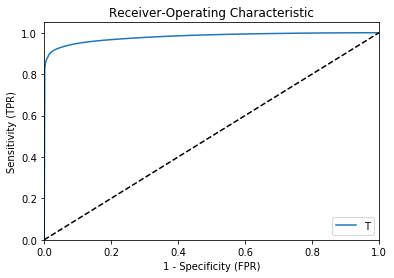

In [87]:
#Plot the ROC curve and determine the optimal cut-off threshold point
#evaluateModel.ROC_AUC(FPR_list, TPR_list)
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(FPR_list, TPR_list)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity (FPR)')
ax.set_ylabel('Sensitivity (TPR)')
ax.set_title('Receiver-Operating Characteristic')
ax.legend('T',loc = "lower right")
    

In [116]:
#This section is made to analyze how well the model performed overall. 
del model
model = smp.Unet(encoder_name = ENCODER, in_channels=1, classes = 1, aux_params = aux_params)
modelPath = "/home/mccrinbc/Registered_Brains_FA/models_saved/TBI_model-End-2020-09-30-19.pt"
model.load_state_dict(torch.load(modelPath))
model.eval() #put into evaluation mode
model.to(torch.device('cpu'))
    
#These need to be the results correspodning to the model you're loading. 
with open('results_TBI_model-End-2020-09-30-19.pkl','rb') as f:  
    brains, labels, predictions, single_class, loss_train, loss_valid, epochLoss_train, epochLoss_valid, test_dataset = pickle.load(f)

loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = num_workers)

#data is called from the loader as loader.dataset[image-label_number][0 OR 1] (shape: [1,256,256])

In [117]:
print(test_dataset.transform)

Compose(
    RandomAffine(degrees=(0, 0), scale=[1, 1])
    RandomHorizontalFlip(p=0)
    Pad(padding=37, fill=0, padding_mode=constant)
    ToTensor()
)


In [118]:
def load_image_result(loader, index, model, threshold):
    #The model expects there to be a batch of images. Need to specify a single image in batch. 
    
    brain = loader.dataset[index][0].unsqueeze(0) #index brain/label, get brain only, compress to only 2D
    label = loader.dataset[index][1][0]
    
    predictions, _ = model(brain)
    predictions = torch.sigmoid(predictions) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
    #fig.suptitle('Brain, True Label, Prediction')
    ax1.imshow(brain[0][0].detach().numpy())
    ax2.imshow(label.detach().numpy())
    ax3.imshow(predictions[0][0].detach().numpy() > best_thresh)

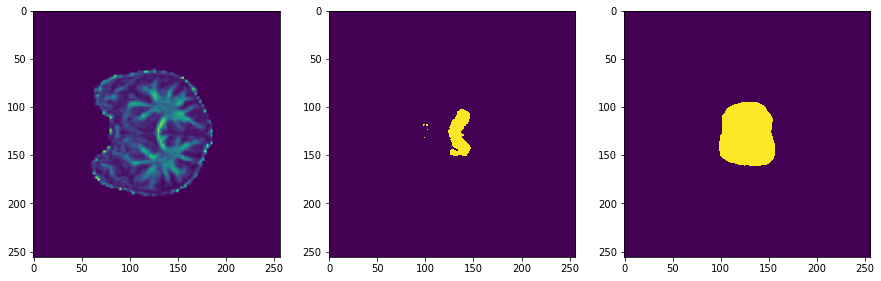

In [122]:
load_image_result(loader, 30, model, best_thresh) #Takes a second to run if on CPU. 

#non-deterministic behaviour might be occuring because of the transform function explicity built into the
#dataset call above. Potentially retrain and remove transform from testing dataset. 

#Each call of loader.dataset could be passing in the FIRST image you expect through a set of RANDOM transformations
#This would make sense as to why we're getting randomness. 

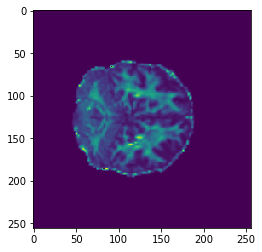

In [121]:
 plt.imshow(loader.dataset[0][0][0])

In [106]:
#Load the brains, Determine the Predictions, Threshold the prediction with optimal value, plot

image_loc = 1
brains, labels = loader[2] #Pick batches you'd like to see. Must be <= batch_total

predictions, _ = model(brains)
predictions = torch.sigmoid(predictions)

predictions = predictions > best_thresh #not sure if this is going to work with a batch of images. 

plt.subplot(1,2,1)
plt.imshow(predictions[image_loc,0,:,:])
plt.subplot(1,2,2)
plt.plt(labels[image_loc,0,:,:])

TypeError: 'DataLoader' object is not subscriptable